# 打开股票量化的黑箱(自己动手实现一个‘印钞机’) 第三章

### 作者：阿布🐶

### 未经本人允许禁止转载

##  ‘非均衡胜负收益’带来的必然’非均衡胜负比例‘，目标由’因子‘的能力解决一部分，’模式识别‘提升关键的一部分

本章开始说文章的核心了，**模式识别提升关键的一部分** 本章的内容主要是通过机器学习如svm，随机森林等对股票模式识别的初步探索，俗称罪恶的第一步，但还是要坚定的卖出，毕竟目标是印钞机

### 下面的工作运行因子对多年数据进行回测，模式识别中基本的需求就是生成训练集数据与测试集数据，对训练集的数据抽取特质，总结规律，在测试集上指导交易，与没有指导交易的测试集进行比对，查看效果

In [1]:
import ZEnv
import ZLog
import ZCommonUtil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import BuyGoldenFactor

In [ ]:
BuyGoldenFactor.g_enable_filter_ml = True # 回测因子的历史且结果集加入机器学习需要的数据
BuyGoldenFactor.g_enable_snap = True # 生成交易这一时刻60日图像，为深度学习准备, 详情见第四章
buy_factors = [{'XD': 42, 'class': BuyGoldenFactorClass, 'draw': True}]

# n_folds： 6年数据回测生成五年单子
# train_test_split：回测时预留一份股票代码表作为测试集，生成9份训练集，当use_last_test为True 时只用一份测试股票代码表进行因子回测
# ret_cnt_need ＝ 0：回测所有股票
out, orders_pd_train_snap = MetricsManger.make_metrics_rsc_mul_symbol_grid(buy_factors, n_folds=6, 
    score_type=METRICSTYPE.SYSMBOL_R_SCORES_GOLDEN.value, ret_cnt_need=0, train_test_split=True, 
    use_last_test=False, force_one_process=False)

In [16]:
# 使用hdf5将这些返回数据缓存，可以只从缓存加载，节约时间
orders_pd_train_snap = ZCommonUtil.load_hdf5('orders_pd_train_snap', 'orders_pd_train_snap')

In [91]:
pd.options.display.max_columns = 40
orders_pd_train_snap.tail(2) # 看看添加了提供机器学习数据的pandas

,buy Date,buy Price,buy Cnt,buyFactor,Sell Date,Sell Price,Sell Type,Symbol,MaxLoss,ExtraInfo,key,profit,result,sell_type_extra,R,sharpe,profit_cg,profit_cg_hunder,keep_days,lowBkCnt,his_miss_days,atr_std,deg_hisWindowPd,deg_windowPd,deg_60WindowPd,jump_power,diff_days,wave_score1,wave_score2,wave_score3,snap,symbol_index
2012-08-28,20120828,26.79,7465,BuyGoldenFactorClass:42,20120905,24.460,loss,usMSB,19.17,"{'wave_score3': -0.44112256310114328, 'wave_sc...",498,-17393.45,-1,BuyGoldenFactorClass:42: lossPrice :below200,-0.305774,-4.42247,-0.086973,-8.697275,8,1,0,0.985224,3.939047,-1.154262,3.300417,-1.111737,35,-0.121029,-0.200734,-0.441123,/Users/Bailey/Desktop/my_work/abu/data/save_pn...,6
2012-08-30,20120830,21.74,9199,BuyGoldenFactorClass:42,20120905,21.365,loss,usINDY,19.16,"{'wave_score3': -0.89585840169126973, 'wave_sc...",500,-3449.62,-1,mv_pre_atr preClose 2.0,-0.145349,0.329131,-0.017249,-1.724929,6,1,0,0.089305,-5.110612,1.030533,3.618710,-4.396298,37,-0.552357,-0.595897,-0.895858,/Users/Bailey/Desktop/my_work/abu/data/save_pn...,6



## 下面生成测试集数据

        BuyGoldenFactor.g_enable_fiter = False
        use_last_test=True

In [ ]:
BuyGoldenFactor.g_enable_fiter = False
BuyGoldenFactor.g_enable_snap = True
buy_factors = [{'XD': 42, 'class': BuyGoldenFactorClass, 'draw': True}]
out, orders_pd_test = MetricsManger.make_metrics_rsc_mul_symbol_grid(buy_factors, n_folds=6, 
    score_type=METRICSTYPE.SYSMBOL_R_SCORES_GOLDEN.value, ret_cnt_need=0, train_test_split=False, 
    use_last_test=True, force_one_process=False)

In [20]:
orders_pd_test_snap = ZCommonUtil.load_hdf5('orders_pd_test_snap', 'orders_pd_test_snap')

(4956, 32)

In [21]:
orders_pd_train_snap.shape, orders_pd_test_snap.shape

((44412, 32), (4956, 32))

### 对训练集及测试集的结果进行大体的度量：主要就是看看**‘非均衡胜负收益’带来的必然’非均衡胜负比例‘，目标由’因子‘的能力解决一部分**效果怎么样

In [69]:
from UmpMain import UmpMainClass
from MlFiterGoldenPd import MlFiterGoldenPdClass

all fit order = (41225, 32)
win rate = 0.493559733172
profit_cg.sum() = 281.687935222
win mean = 0.0770327160087 loss_mean = -0.061738192442 


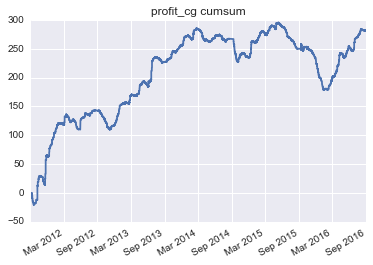

In [71]:
train_ump = UmpMainClass(orders_pd_train_snap, MlFiterGoldenPdClass)
train_ump.show_general()

all fit order = (4612, 32)
win rate = 0.5
profit_cg.sum() = 37.4002795407
win mean = 0.076550446692 loss_mean = -0.0605681543452 


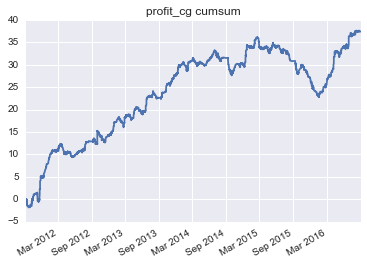

In [74]:
test_ump = UmpMainClass(orders_pd_test_snap, MlFiterGoldenPdClass)
test_ump.show_general()

显示在所有有结果的单子中胜率可以接近一半，且每次赢的0.07比没次输的0.06多，
但是贪婪的我仍然认为有优化空间，这个空间就是利用这个因子产生的输出数据
作为特征识别基础，提炼特征，指导交易，

**’模式识别‘提升关键的一部分**

下面我们看看如何做到的呢

首先确认ml封装库是否能正常运行

In [34]:
from MlFiter import MlFiterClass
test_fiter = MlFiterClass.create_test_fiter()
test_fiter_more = MlFiterClass.create_test_more_fiter()

**学习曲线**

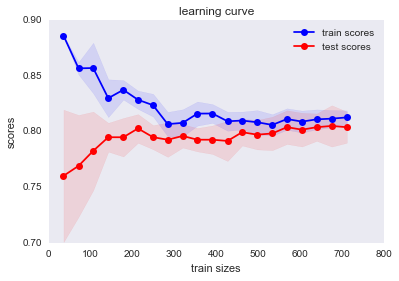

(0.80412095046015697, 0.028989030232112856)

In [35]:
test_fiter_more.estimator.logistic_regression()
test_fiter_more.plot_learning_curve()

**特征权重**

In [36]:
test_fiter.importances_coef_pd()

******************DecisionTreeClassifier******************


,feature,importance
0,x0,0.013333
1,x1,0.013333
3,x3,0.422611
2,x2,0.550723


**树逻辑图**

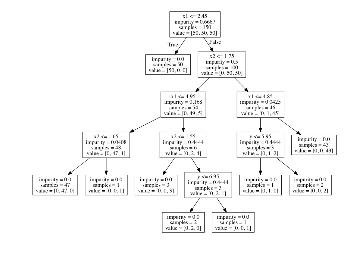

In [38]:
test_fiter.plot_graphviz_tree()
path = ZEnv.shell_cmd_result('pwd') + '/graphviz.png'
!open $path

**混淆矩阵**

[[453  96]
 [100 242]]


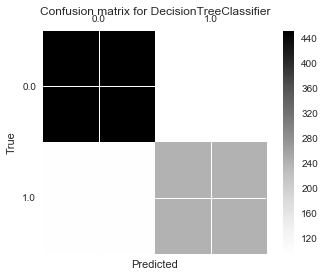

In [39]:
test_fiter_more.plot_confusion_matrices()

**roc**

DecisionTreeClassifier :roc


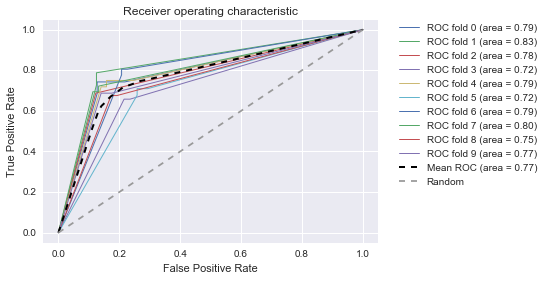

In [41]:
test_fiter_more.plot_roc_estimator()

**特征选择**

In [42]:
test_fiter_more.feature_selection()

RFE selection
             ranking support
SibSp              1    True
Parch              1    True
Cabin_No           1    True
Cabin_Yes          6   False
Embarked_C         2   False
Embarked_Q         5   False
Embarked_S         3   False
Sex_female         8   False
Sex_male           1    True
Pclass_1           4   False
Pclass_2           7   False
Pclass_3           1    True
Age_scaled         1    True
Fare_scaled        1    True

RFECV selection
             ranking support
SibSp              1    True
Parch              2   False
Cabin_No           1    True
Cabin_Yes          7   False
Embarked_C         3   False
Embarked_Q         8   False
Embarked_S         4   False
Sex_female         1    True
Sex_male           9   False
Pclass_1           5   False
Pclass_2           6   False
Pclass_3           1    True
Age_scaled         1    True
Fare_scaled        1    True


**决策边界**

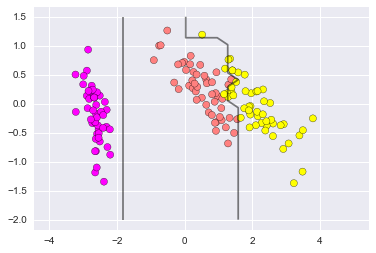

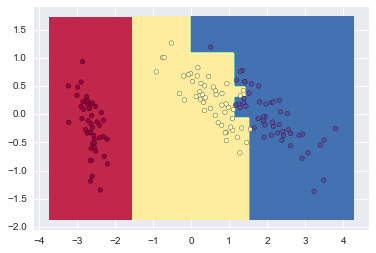

In [44]:
test_fiter.plot_decision_function()

**train test score**

In [45]:
test_fiter_more.cross_val_accuracy_score()

accuracy mean: 0.776812507093


array([ 0.75555556,  0.72222222,  0.73033708,  0.75280899,  0.83146067,
        0.78651685,  0.80898876,  0.71910112,  0.82022472,  0.84090909])

**切换使用其它学习方法**

In [46]:
test_fiter_more.estimator.adaboost_classifier()
test_fiter_more.cross_val_accuracy_score()

accuracy mean: 0.810433548973


array([ 0.78888889,  0.78888889,  0.78651685,  0.80898876,  0.84269663,
        0.78651685,  0.82022472,  0.82022472,  0.79775281,  0.86363636])

### 可以证明封装库没有问题，可以放心使用，下一步上真正的股票数据

In [49]:
from MlFiterDegPd import MlFiterDegPdClass

由252，60， 42天组成的走势数剧作为特质开始

In [76]:
deg = MlFiterDegPdClass(orderPd=orders_pd_train_snap)
deg.df.head()

,result,deg_hisWindowPd,deg_windowPd,deg_60WindowPd
2015-09-11,0,0.139976,0.070454,0.068291
2015-09-11,0,-0.409467,-0.388299,0.750276
2015-09-11,0,11.841444,-0.846906,2.738821
2015-09-11,0,-17.266100,-3.578966,-3.861270
2015-09-11,1,-9.146706,4.145140,2.854837


In [52]:
# 上来就来个强模型，svm
deg().estimator.svc()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
deg().cross_val_accuracy_score()

accuracy mean: 0.491279520472


array([ 0.48920689,  0.51758428,  0.49987873,  0.49551298,  0.48168809,
        0.4887218 ,  0.47610963,  0.47355653,  0.4853191 ,  0.50521718])

**0.49的准确率，相当于是乱猜** 是不是特征选择的不好呢，换一些特征试试

In [77]:
from MlFiterMainPd import MlFiterMainPdClass

In [78]:
from MlFiterMainPd import MlFiterMainPdClass
main = MlFiterMainPdClass(orderPd=orders_pd_train_snap)
main.df.head()

,result,atr_std,deg_60WindowPd,wave_score1
2015-09-11,0,0.176934,0.068291,0.338000
2015-09-11,0,0.580693,0.750276,0.769249
2015-09-11,0,1.438411,2.738821,0.242423
2015-09-11,0,2.061893,-3.861270,0.930900
2015-09-11,1,1.022388,2.854837,1.650291


In [80]:
main().cross_val_accuracy_score()

accuracy mean: 0.493608245706


array([ 0.5008489 ,  0.49890856,  0.49793839,  0.48678147,  0.50303177,
        0.47125879,  0.49648314,  0.49369238,  0.49332686,  0.49381218])

**0.49的准确率，还是乱猜** 是不是特征太少了，构建一个特征多的试试

In [85]:
from MlFiter import MlFiterClass
order_has_ret = orders_pd_train_snap[(orders_pd_train_snap.result <> 0)]

all_pd = order_has_ret.filter(['result', 'deg_hisWindowPd', 'deg_windowPd', 'deg_60WindowPd', 'atr_std', 'jump_power', 
                               'diff_days', 'wave_score1', 'wave_score2', 'wave_score23'])
train_np = all_pd.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]
all_filter = MlFiterClass(x, y, all_pd)
all_pd.head()

,result,deg_hisWindowPd,deg_windowPd,deg_60WindowPd,atr_std,jump_power,diff_days,wave_score1,wave_score2
2015-09-11,-1,0.139976,0.070454,0.068291,0.176934,-1.390000,48,0.338000,0.376933
2015-09-11,-1,-0.409467,-0.388299,0.750276,0.580693,-2.144082,106,0.769249,0.844728
2015-09-11,-1,11.841444,-0.846906,2.738821,1.438411,0.000000,0,0.242423,0.074236
2015-09-11,-1,-17.266100,-3.578966,-3.861270,2.061893,-2.621604,100,0.930900,0.966207
2015-09-11,1,-9.146706,4.145140,2.854837,1.022388,-1.081679,353,1.650291,1.655261


In [88]:
# 这回使用随机森林
all_filter.estimator.random_forest_classifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
all_filter.cross_val_accuracy_score()

accuracy mean: 0.505349477658


array([ 0.48678147,  0.50788261,  0.53019646,  0.50497211,  0.51297599,
        0.46058695,  0.51564395,  0.50994663,  0.4942975 ,  0.53021111])

**0.50的准确率，这算是有所提升吗？😥**

### 下面使用把数据离散化后，换种分类器测试

In [55]:
deg = MlFiterDegPdClass(orderPd=orders_pd_train_snap, dummies=True, invoke_hmm=False,
                       invoke_pca=False)
deg.df.head()

,result,"dh_dummies_(-inf, -20]","dh_dummies_(-20, -12]","dh_dummies_(-12, -7]","dh_dummies_(-7, -3]","dh_dummies_(-3, 0]","dh_dummies_(0, 3]","dh_dummies_(3, 7]","dh_dummies_(7, 12]","dh_dummies_(12, 20]","dh_dummies_(20, inf]","dw_dummies_(-inf, -20]","dw_dummies_(-20, -12]","dw_dummies_(-12, -7]","dw_dummies_(-7, -3]","dw_dummies_(-3, 0]","dw_dummies_(0, 3]","dw_dummies_(3, 7]","dw_dummies_(7, 12]","dw_dummies_(12, 20]","dw_dummies_(20, inf]","d60_dummies_(-inf, -20]","d60_dummies_(-20, -12]","d60_dummies_(-12, -7]","d60_dummies_(-7, -3]","d60_dummies_(-3, 0]","d60_dummies_(0, 3]","d60_dummies_(3, 7]","d60_dummies_(7, 12]","d60_dummies_(12, 20]","d60_dummies_(20, inf]"
2015-09-11,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2015-09-11,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2015-09-11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2015-09-11,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-09-11,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**离散值的选择通过统计挖掘**

上边封住好了的，在离散值的选择上不是瞎来的，会通过可视化来选择离散值bins，如下所示，这里的核心思想就是不要拍脑袋使用自己觉的对的任何常数值，**通过数据来指导数据最终指导交易**

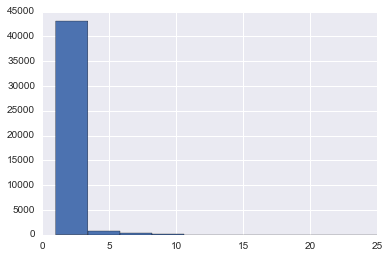

lowBkCnt show hist and qcuts
[1, 3.3]        43098
(3.3, 5.6]        743
(5.6, 7.9]        243
(7.9, 10.2]       175
(10.2, 12.5]       42
(12.5, 14.8]       41
(14.8, 17.1]       40
(17.1, 19.4]       13
(19.4, 21.7]        9
(21.7, 25]          8
Name: lowBkCnt, dtype: int64


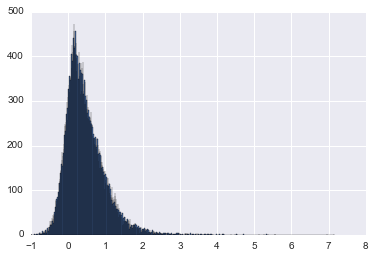

atr_std show hist and qcuts
(1.116, 7.141]       4442
[-0.999, -0.0925]    4442
(0.826, 1.116]       4441
(0.633, 0.826]       4441
(0.483, 0.633]       4441
(0.36, 0.483]        4441
(0.249, 0.36]        4441
(0.152, 0.249]       4441
(0.0476, 0.152]      4441
(-0.0925, 0.0476]    4441
Name: atr_std, dtype: int64


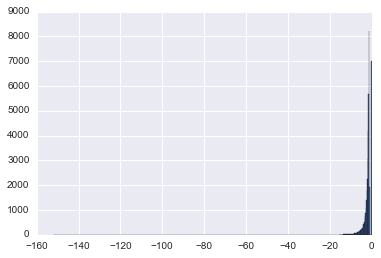

jump_power show hist and qcuts
(-1.0792, 0]          10760
(-1.42, -1.282]        3754
[-151.515, -4.253]     3754
(-1.824, -1.589]       3746
(-2.785, -2.176]       3744
(-1.282, -1.173]       3741
(-1.173, -1.0792]      3738
(-2.176, -1.824]       3734
(-4.253, -2.785]       3725
(-1.589, -1.42]        3716
Name: jump_power, dtype: int64


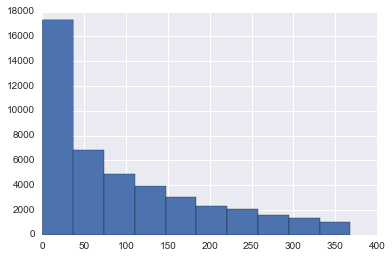

diff_days show hist and qcuts
[0, 36.8]         17330
(36.8, 73.6]       6851
(73.6, 110.4]      4890
(110.4, 147.2]     3937
(147.2, 184]       3093
(184, 220.8]       2256
(220.8, 257.6]     2082
(257.6, 294.4]     1630
(294.4, 331.2]     1319
(331.2, 368]       1024
Name: diff_days, dtype: int64


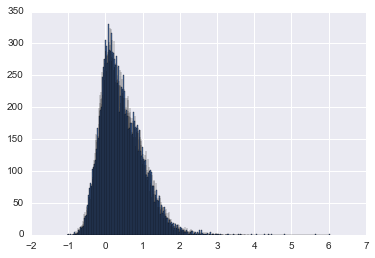

wave_score1 show hist and qcuts
(1.199, 6.0266]      4442
[-1.0169, -0.184]    4442
(0.899, 1.199]       4441
(0.689, 0.899]       4441
(0.506, 0.689]       4441
(0.353, 0.506]       4441
(0.219, 0.353]       4441
(0.0986, 0.219]      4441
(-0.0262, 0.0986]    4441
(-0.184, -0.0262]    4441
Name: wave_score1, dtype: int64


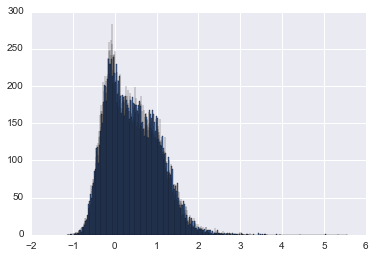

wave_score2 show hist and qcuts
(1.271, 5.558]       4442
[-1.122, -0.308]     4442
(0.994, 1.271]       4441
(0.768, 0.994]       4441
(0.557, 0.768]       4441
(0.361, 0.557]       4441
(0.172, 0.361]       4441
(0.00248, 0.172]     4441
(-0.138, 0.00248]    4441
(-0.308, -0.138]     4441
Name: wave_score2, dtype: int64


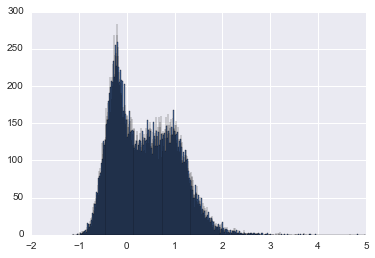

wave_score3 show hist and qcuts
(1.26, 4.992]       4442
[-1.126, -0.394]    4442
(1.0024, 1.26]      4441
(0.786, 1.0024]     4441
(0.556, 0.786]      4441
(0.322, 0.556]      4441
(0.0828, 0.322]     4441
(-0.107, 0.0828]    4441
(-0.24, -0.107]     4441
(-0.394, -0.24]     4441
Name: wave_score3, dtype: int64


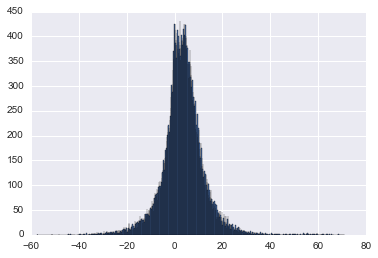

deg_60WindowPd show hist and qcuts
(13.0319, 70.936]     4442
[-57.515, -6.0276]    4442
(9.102, 13.0319]      4441
(6.817, 9.102]        4441
(4.999, 6.817]        4441
(3.406, 4.999]        4441
(1.735, 3.406]        4441
(0.1, 1.735]          4441
(-1.955, 0.1]         4441
(-6.0276, -1.955]     4441
Name: deg_60WindowPd, dtype: int64


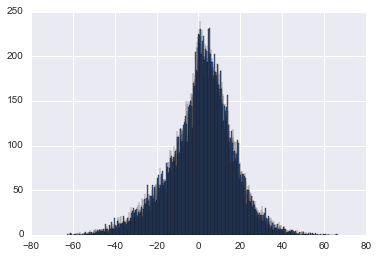

deg_hisWindowPd show hist and qcuts
(19.339, 66.766]       4442
[-62.804, -19.0819]    4442
(13.183, 19.339]       4441
(9.0385, 13.183]       4441
(5.578, 9.0385]        4441
(2.382, 5.578]         4441
(-0.625, 2.382]        4441
(-4.6, -0.625]         4441
(-10.187, -4.6]        4441
(-19.0819, -10.187]    4441
Name: deg_hisWindowPd, dtype: int64


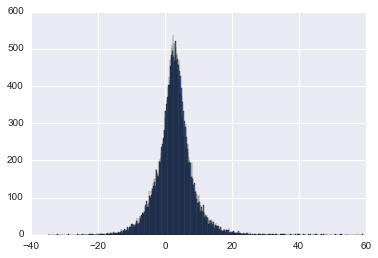

deg_windowPd show hist and qcuts
(8.921, 59.0546]     4442
[-34.752, -3.519]    4442
(6.363, 8.921]       4441
(4.863, 6.363]       4441
(3.776, 4.863]       4441
(2.826, 3.776]       4441
(1.876, 2.826]       4441
(0.763, 1.876]       4441
(-0.802, 0.763]      4441
(-3.519, -0.802]     4441
Name: deg_windowPd, dtype: int64


In [58]:
import MlFiterBinsCs
MlFiterBinsCs.show_orders_hist(orders_pd_train_snap)

In [59]:
deg().estimator.random_forest_classifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
deg().cross_val_accuracy_score()

accuracy mean: 0.487590577522


array([ 0.48217317,  0.51564395,  0.4962406 ,  0.49890856,  0.49745331,
        0.48338588,  0.49527043,  0.45414847,  0.44479495,  0.50788644])

**结果还是乱猜**

用其它等等方式仍然是胡猜，自己写的类似adaboost依然效果很差
通过非均衡概率降低假阳，提高假阴的方式，最后统计所有测试集样本的判别
概率发现其实还瞎猜

### 提高分类数量，设置阀值，提高准确率的方案


**通过将profit cg qcut 100份分类**

In [63]:
orders_pd_train_snap.profit_cg.fillna(0, inplace=True)
order_has_ret = orders_pd_train_snap[(orders_pd_train_snap.result <> 0)]
n_class = 100
order_has_ret['class'] = pd.qcut(order_has_ret.profit_cg, n_class, labels=range(0, n_class))
order_has_ret['class'] = order_has_ret['class'].astype(int)
ZLog.info(np.unique(order_has_ret['class']))

deg_pd = order_has_ret.filter(['class', 'result', 'deg_hisWindowPd', 'deg_windowPd', 'deg_60WindowPd'])
train_np = deg_pd.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]
deg = MlFiterClass(x, y, deg_pd, force_clf=True)
deg_pd.head()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]


,class,result,deg_hisWindowPd,deg_windowPd,deg_60WindowPd
2015-09-11,49,-1,0.139976,0.070454,0.068291
2015-09-11,48,-1,-0.409467,-0.388299,0.750276
2015-09-11,48,-1,11.841444,-0.846906,2.738821
2015-09-11,19,-1,-17.266100,-3.578966,-3.861270
2015-09-11,82,1,-9.146706,4.145140,2.854837


* y为class train_test_split进行分类
* 使用cv数据集的 predict < class阀值 使用result==0的情况查看概率

In [64]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

deg.estimator.random_forest_classifier()

train_df, cv_df = train_test_split(deg.df, test_size=0.1, random_state=0)

fiter = deg.get_fiter()
fiter.fit(train_df.as_matrix()[:, 2:], train_df.as_matrix()[:, 0])

predictions = fiter.predict(cv_df.as_matrix()[:, 2:])

cv_df['predict'] = predictions
cv_df.head()

,class,result,deg_hisWindowPd,deg_windowPd,deg_60WindowPd,predict
2011-09-14,18,-1,5.985684,-6.237572,-6.587850,18.0
2011-12-01,50,1,-2.001929,3.420615,5.567589,70.0
2014-01-30,82,1,22.816944,4.173005,6.782197,87.0
2015-11-16,3,-1,12.867986,-3.698409,-12.211724,21.0
2015-12-18,40,-1,-12.460329,5.803071,11.280990,23.0


In [65]:
cv_df['predict'].value_counts().sort_index().head(10)

0.0    56
1.0    50
2.0    43
3.0    47
4.0    44
5.0    45
6.0    47
7.0    30
8.0    46
9.0    39
Name: predict, dtype: int64

In [66]:
for threshold in np.arange(0, 10):
    ppv = cv_df[cv_df['predict'] <= threshold].result.value_counts()
    ZLog.info('threshold: {}, ppv: {}'.format(threshold, float(ppv[-1])/ppv.sum()))

threshold: 0, ppv: 0.607142857143
threshold: 1, ppv: 0.632075471698
threshold: 2, ppv: 0.58389261745
threshold: 3, ppv: 0.586734693878
threshold: 4, ppv: 0.579166666667
threshold: 5, ppv: 0.571929824561
threshold: 6, ppv: 0.551204819277
threshold: 7, ppv: 0.541436464088
threshold: 8, ppv: 0.526960784314
threshold: 9, ppv: 0.523489932886


### threshold: 0，1，达到0.6了 但是数量上只有100多个，之后会有使用gmm－hmm的方式继续扩展这种思路，提高收益

### 只能说最后一种的这个思想可以作为扩展使用，实际中由于 '非均衡胜负收益' 很难带来质的好转，突然想到阿西莫夫的小说基地，对心理史学的最开始的评估，‘可能但是不可行’，我们的印钞机之路是否也是这样呢，下一章开始就是真正的印钞机之路了，一个即可能又可行之路！！！ 下一章开始将使用深度学习方法来训练数据，提高胜率主要是卷机神经网络的使用

## 感谢🙏您能有耐心看到这里
## 如果有什么问题可以加阿布的微信 
## 微信号：aaaabbbuu｀

![image](./mmexport1475383814280.jpg)